# Load all modules

In [1]:
%reload_ext autoreload

%autoreload 2

import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from IPython.display import display

# from scipy.signal import hilbert
# import pygmt
# import xarray as xr


# Set up dataframe display options
# pd.set_option('display.max_rows', 100)

# Library for reading SEG-Y
import segyio

# Python implementation of TEOS-10 equation of state for seawater
import gsw

# SeisMix modules
from SeisMix import read_seismic_data
from SeisMix import miscellaneous_functions
from SeisMix import noise_analysis
from SeisMix import reflection_tracking
from SeisMix import contours_to_midpoints
from SeisMix import average_spectrum
from SeisMix import run_average_spectrum_turbulence_estimation

# Set up parameters

In [2]:
# Set up parameters
# Image parameters
cmp_spacing_m = 12.5 # Common midpoint interval in metres
# sampling_s = 0.002 # Time sampling of seismic traces in seconds

# Region of image to select
cmp_select_min = 550
cmp_select_max = 1600
twt_select_s_min = 0.4
twt_select_s_max = 0.9

# Multi-taper Fourier transform parameters
jres_mtft = 6 
K_mtft = 4

# Reflection tracking parameters
contour_level = 0.6
min_length = 160
cmp_gap = 1
contours_twt_gap = 0.1 
midpoints_twt_gap = 0.008

# Parameters for computation of average spectrum
# average_spectrum_cmp_min=
# average_spectrum_cmp_max=
average_spectrum_twt_min_s=0.4
average_spectrum_twt_max_s=0.9
average_spectrum_number_points=160
averaging_option = "mean_log"

### Set up local oceanographic variables
N_cph = 2
sigma_N_cph = 1
N_rads = 2.*np.pi*N_cph / 3600.
sigma_N_rads = 2.*np.pi*sigma_N_cph / 3600.
latitude_degrees = 27.4
f = gsw.f(latitude_degrees)

### Set up variables for estimation of epsilon from turbulent subrange
min_turb_length = 10
gamma = 0.2
CT = 0.4

### Set up variables for estimation of epsilon from internal wave subrange
### Set up parameters for reference GM spectrum
min_iw_length = 10
gm_option = "gk91"
N0_cph = 3
N0_rads = 2.*np.pi*N0_cph / 3600.
N_GM_cph = 3
N_GM_rads = 2.*np.pi*N_GM_cph / 3600.
E = 6.3e-5
b = 1300
jstar = 4
RwGM = 3

### Set up variables for computation of dissipation rate using reference spectrum
Rw = 7
latitude0 = 30
f0 = gsw.f(latitude0)
f_GM = f0
Rf=1/6 # Flux Richardson number

### Set up variables for integration of kxkz GM spectrum to yield kx spectrum
Nkz=100
logkz_gm_min=-4.
logkz_gm_max=1.
Nkx=100
logkx_gm_min=-6.
logkx_gm_max=-1.
NkH=100
gm_rolloff_option="yes"



# Load data

In [7]:
# Pass files as SEG-Y
input_segy_name="./example_data/input_segy/0801P1_rsg_gp6p25ms50m_sbm_dwrm1470_sdc_bt30sl24_ds1.5_ap1_sm2"
filename = input_segy_name + ".segy"

# Import SEG-Y to numpy objects
cmp_array, cmp_grid, sampling_s, twt_s_array, twt_s_grid, data = read_seismic_data.read_segy(filename)

# Select region of image to analyse
cmp_array_select, cmp_grid_select, twt_s_array_select, twt_s_grid_select, data_select = read_seismic_data.select_image_region(cmp_array, cmp_grid, cmp_select_min, cmp_select_max, twt_s_array, twt_s_grid, twt_select_s_min, twt_select_s_max, data)

<class 'float'>


# Noise analysis

1. Estimate signal-to-noise ratio following method of <a href="https://journals.ametsoc.org/jtech/article/30/8/1767/4525/Estimating-Oceanic-Turbulence-Dissipation-from" target="_blank">Holbrook et al. (2013)</a>

$$
 \textrm{SNR} = \sqrt{\frac{|c|}{|a - c|}}
$$

2. Compute amplitude and phase spectra
3. Compute direct data transform (i.e. amplitude spectrum integrated over frequency) following method of <a href="https://journals.ametsoc.org/jtech/article/30/8/1767/4525/Estimating-Oceanic-Turbulence-Dissipation-from" target="_blank">Holbrook et al. (2013)</a>

In [18]:
# Calculate signal-to-noise-ratio
snr_median_raw, snr_mean_raw, snr_stdev_raw = noise_analysis.estimate_signal_to_noise(data_select)
snr_median, snr_stdev = miscellaneous_functions.round_to_sf(snr_median_raw, snr_stdev_raw)
snr_mean, snr_stdev = miscellaneous_functions.round_to_sf(snr_mean_raw, snr_stdev_raw)

# Compute amplitude and phase spectra
f, kx, amplitude_spectrum_sorted, phase_spectrum_sorted, kx_spectrum, f_spectrum = noise_analysis.make_amplitude_and_phase_spectra(data_select, sampling_s, cmp_spacing_m)

# Compute direct data transform
ddt_kx, ddt_power_spectrum, ddt_power_spectrum_stdev, ddt_slope_spectrum, ddt_slope_spectrum_stdev = noise_analysis.make_direct_data_transform(data_select, cmp_spacing_m, jres_mtft, K_mtft)

# Reflection tracking

1. Convert seismic amplitudes to cosine of the instantaneous phase angle <a href="https://library.seg.org/doi/abs/10.1190/1.2785048" target="_blank">(Barnes, 2007)</a>
2. Contour a constant value `contour_level` of the cosine of the instantaneous phase angle
3. For each contour, calculate midpoints
4. Store all contours in dictionary `all_contours_dict` and all midpoints in dictionary `all_midpoints_dict`

In [29]:
extent = [cmp_array_select[0], cmp_array_select[-1], twt_s_array_select[-1], twt_s_array_select[0]]

cosine_ipa, all_contours = reflection_tracking.contour_reflections(data_select, contour_level, cmp_grid_select, twt_s_grid_select, extent)

all_contours_dict, all_midpoints_dict = reflection_tracking.compute_midpoints(all_contours, min_length, cmp_gap, contours_twt_gap, midpoints_twt_gap)

number_reflections, reflection_length_array, overall_reflection_length_m, mean_reflection_length_m_raw, std_reflection_length_m_raw, median_reflection_length_m_raw = reflection_tracking.calculate_reflection_statistics(all_midpoints_dict, cmp_spacing_m)

print(type(mean_reflection_length_m))

mean_reflection_length_m, std_reflection_length_m = miscellaneous_functions.round_to_sf(mean_reflection_length_m_raw, std_reflection_length_m_raw)

<class 'numpy.float64'>


# Spectral analysis

## Average spectrum

1. Compute average spectrum using all tracked reflections. Options: averaging in log or linear space
2. Identify turbulent subrange of average spectrum and estimate epsilon and K from this subrange

Rewrite text as from Dickinson (2020): Four parameters control the exact form of the model: the gradient, $a$, of the low-wavenumber subrange; the co-ordinates, $(b,c)$, of the intersection point between the low-wavenumber and turbulent regimes; and the width, $d$, of the turbulent subrange. The model is fitted by defining a misfit function 
$$
M_1 = \sum_{i=0}^M \left[\left[\log_{10}(\phi_{\xi_x}^m) \right]_i - \left[\log_{10}( \left\langle \phi_{\xi_x} \right\rangle_p ) \right]_i\right]^2
$$
where $\phi_{\xi_x}^m$ is the model and $M$ is the number of points in the power spectrum. Best-fitting values of $a$, $b$, $c$ and $d$ are found by minimizing $M_1$ using Powell's conjugate direction algorithm \citep{Powell1964}.

[-2.54174297 -1.89313484  0.84711247 -1.86857593]


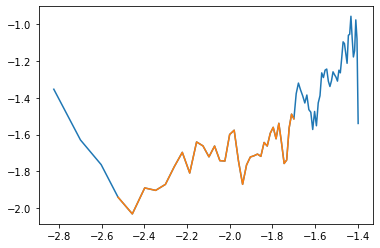

-1.036304860713849 0.09859620482322458
-9.328274912006464 0.6680187455368326 logepsilon, sigma_logepsilon
-5.1130596428521 0.2627273308306081 logkt, sigma_logkt


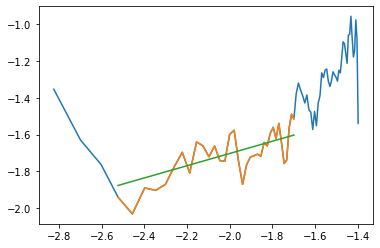

In [6]:
# Compute average spectrum
average_spectrum_array = average_spectrum.make_welch_average_spectrum(cmp_spacing_m, average_spectrum_number_points, all_midpoints_dict, average_spectrum_twt_min_s, average_spectrum_twt_max_s)

# TODO: turn turbulence mixing estimation into one module that can be used for average and individual spectra
# Estimate mixing rate from turbulent subrange
run_average_spectrum_turbulence_estimation.estimate_mixing(average_spectrum_array, N_cph, sigma_N_cph, latitude_degrees, gamma, CT, gm_option, N0_cph, N_GM_cph, E, b, jstar, RwGM, Rw, latitude0, Rf, Nkz, logkz_gm_min, logkz_gm_max, Nkx, logkx_gm_min, logkx_gm_max, NkH, gm_rolloff_option, min_turb_length, min_iw_length, averaging_option)


# Make all plots

## Plot entire seismic image with box outlining selected area

Text(0, 0.5, 'TWT [ms]')

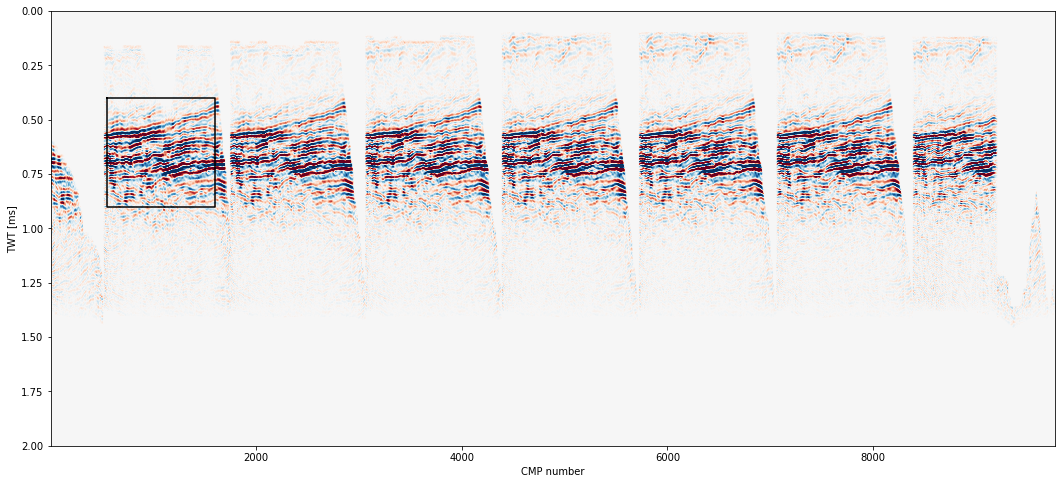

In [7]:
clip_percentile = 99
vm = np.percentile(data, clip_percentile)
# f'The {clip_percentile}th percentile is {vm:.0f}; the max amplitude is {data.max():.0f}'
selection_box = np.array([[cmp_array_select[0], twt_s_array_select[0]],[cmp_array_select[0], twt_s_array_select[-1]],[cmp_array_select[-1], twt_s_array_select[-1]],[cmp_array_select[-1], twt_s_array_select[0]],[cmp_array_select[0], twt_s_array_select[0]]])

fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(1, 1, 1)
extent = [cmp_array[0], cmp_array[-1], twt_s_array[-1], twt_s_array[0]]  # define extent
ax.imshow(data, cmap="RdBu", vmin=-vm, vmax=vm, aspect='auto', extent=extent)
ax.plot(selection_box[:,0], selection_box[:,1], color='black')
ax.set_xlabel('CMP number')
ax.set_ylabel('TWT [ms]')


## Plot selected area of seismic image

Text(0, 0.5, 'TWT [ms]')

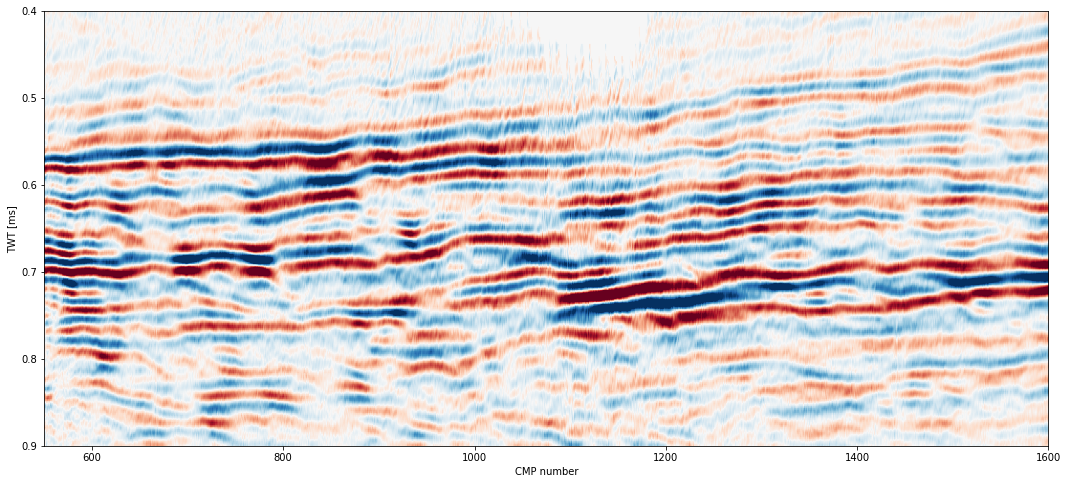

In [8]:
clip_percentile = 99
vm = np.percentile(data_select, clip_percentile)
f'The {clip_percentile}th percentile is {vm:.0f}; the max amplitude is {data_select.max():.0f}'

fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(1, 1, 1)
extent = [cmp_array_select[0], cmp_array_select[-1], twt_s_array_select[-1], twt_s_array_select[0]]  # define extent
ax.imshow(data_select, cmap="RdBu", vmin=-vm, vmax=vm, aspect='auto', extent=extent)
ax.set_xlabel('CMP number')
ax.set_ylabel('TWT [ms]')

## Plot results of noise analysis

snr_mean:  9.0 ± 11.0
snr_median:  7.0


Text(0, 0.5, 'Amplitude / arbitrary units')

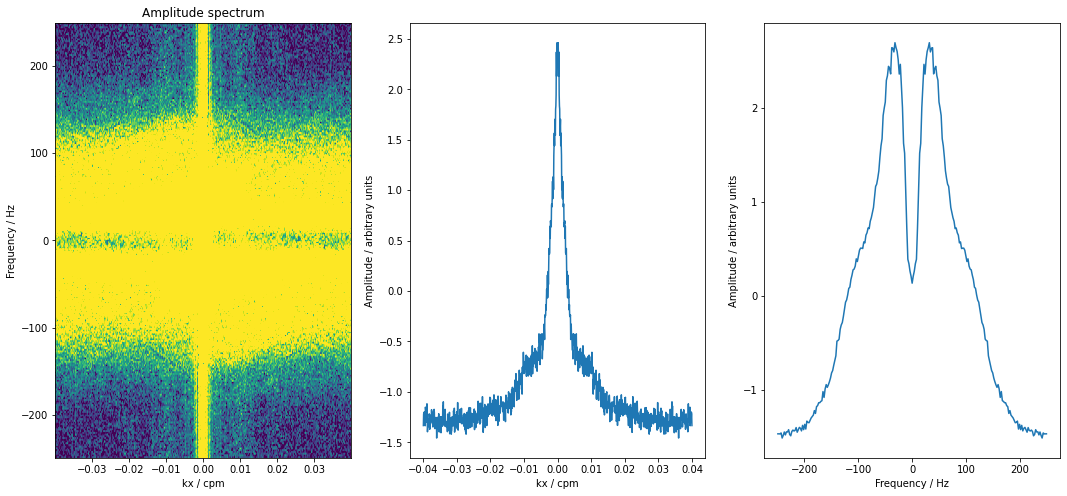

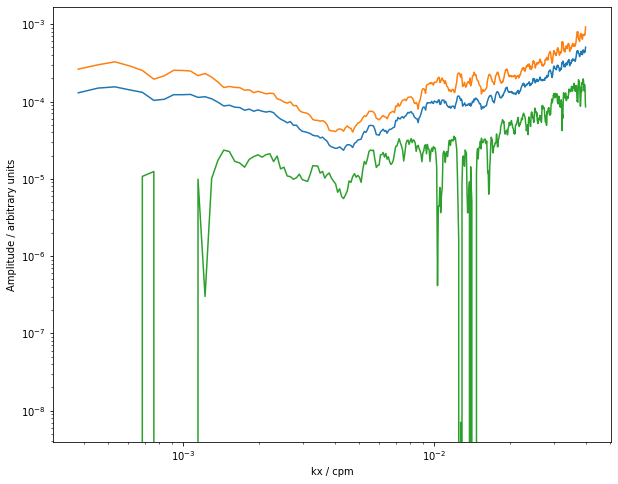

In [9]:
print("snr_mean: ", snr_mean, "±", snr_stdev)
print("snr_median: ", snr_median)

# Plot amplitude spectrum as 2D plot and against kx and frequency 
fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(1, 3, 1)
extent = [kx[0], kx[-1], f[0], f[-1]] 
ax.imshow(amplitude_spectrum_sorted, aspect='auto', extent=extent, norm=LogNorm(vmin=0.0001, vmax=.001))
ax.set_xlabel('kx / cpm')
ax.set_ylabel('Frequency / Hz')
ax.set_title('Amplitude spectrum')
ax = fig.add_subplot(1,3,2)
ax.plot(kx, np.log(kx_spectrum))
ax.set_xlabel('kx / cpm')
ax.set_ylabel('Amplitude / arbitrary units')
ax = fig.add_subplot(1,3,3)
ax.plot(f, np.log(f_spectrum))
ax.set_xlabel('Frequency / Hz')
ax.set_ylabel('Amplitude / arbitrary units')

# Plot direct data transform
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)
ax.loglog(ddt_kx, ddt_slope_spectrum)
ax.loglog(ddt_kx, ddt_slope_spectrum + ddt_slope_spectrum_stdev)
ax.loglog(ddt_kx, ddt_slope_spectrum - ddt_slope_spectrum_stdev)
ax.set_xlabel('kx / cpm')
ax.set_ylabel('Amplitude / arbitrary units')

## Plot tracked reflections

1. Tracked reflections overlying seismic image
2. Histogram of lengths of tracked reflections

Number of tracked reflections: 38
Cumulative length of tracked reflections: 148.6125 km
Mean length of tracked reflections: 3.9 ± 2.2 km
Median length of tracked reflections: 3.0 km


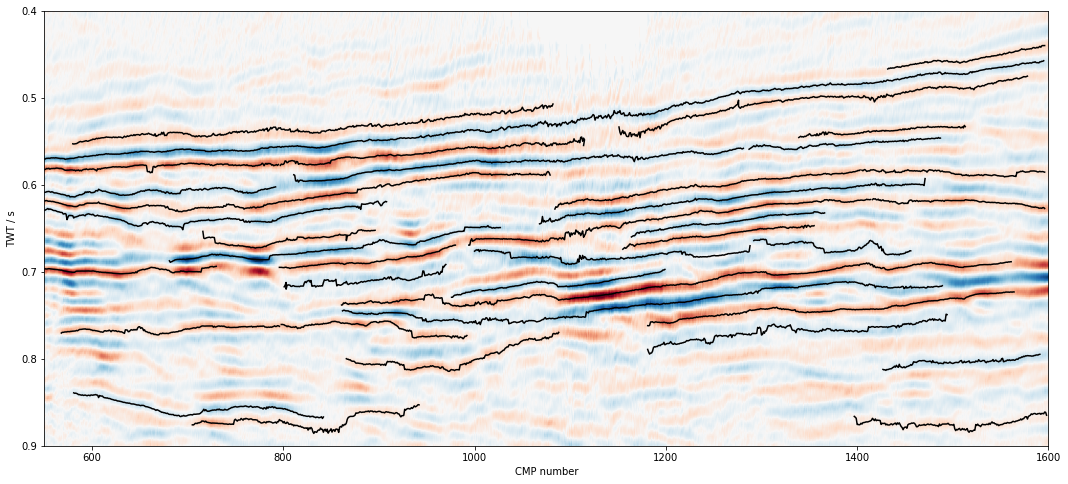

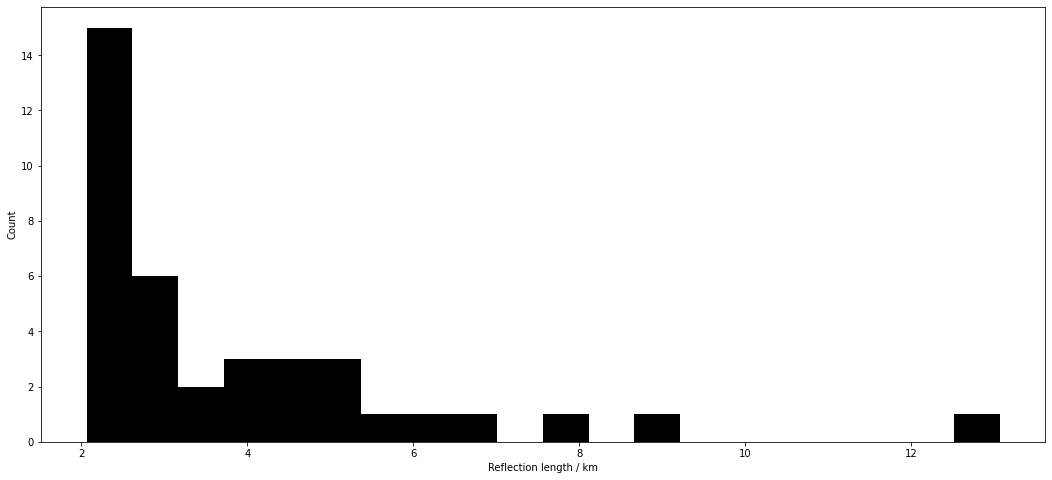

In [11]:
fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(1, 1, 1)
extent = [cmp_array_select[0], cmp_array_select[-1], twt_s_array_select[-1], twt_s_array_select[0]]
ax.imshow(data_select, cmap="RdBu", extent=extent, aspect='auto', interpolation=None, vmin=-2*vm, vmax=2*vm)
extent = [cmp_array_select[0], cmp_array_select[-1], twt_s_array_select[0], twt_s_array_select[-1]]
for i in all_midpoints_dict:
    ax.plot(all_midpoints_dict[i][:,0], all_midpoints_dict[i][:,1], color="black")
ax.set_xlabel('CMP number')
ax.set_ylabel('TWT / s')

print("Number of tracked reflections:", number_reflections)
print("Cumulative length of tracked reflections:", overall_reflection_length_m / 1000, "km")
print("Mean length of tracked reflections:", mean_reflection_length_m / 1000, "±", std_reflection_length_m / 1000, "km")
print("Median length of tracked reflections:", median_reflection_length_m_raw / 1000, "km")

fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(1, 1, 1)
ax.hist(cmp_spacing_m * reflection_length_array/1000, bins=20, color='black')
ax.set_xlabel("Reflection length / km")
ax.set_ylabel("Count")
plt.show()
    

## Plot average spectrum computed from all tracked reflections

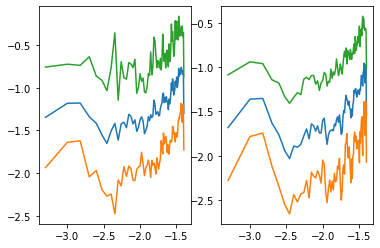

In [12]:
average_spectrum_kx = average_spectrum_array[:,0]
average_slope_spectrum = average_spectrum_array[:,1]
std_slope_spectrum = average_spectrum_array[:,2]
average_spectrum_logkx = average_spectrum_array[:,3]
average_spectrum_log10_mean_linear = average_spectrum_array[:,4]
average_spectrum_log10_mean_linear_std = average_spectrum_array[:,5]
average_spectrum_mean_log10 = average_spectrum_array[:,6]
average_spectrum_mean_log10_std = average_spectrum_array[:,7]

plt.subplot(121)
plt.plot(average_spectrum_logkx, average_spectrum_log10_mean_linear)
plt.plot(average_spectrum_logkx, average_spectrum_log10_mean_linear - average_spectrum_log10_mean_linear_std)
plt.plot(average_spectrum_logkx, average_spectrum_log10_mean_linear + average_spectrum_log10_mean_linear_std)
plt.subplot(122)
plt.plot(average_spectrum_logkx, average_spectrum_mean_log10)
plt.plot(average_spectrum_logkx, average_spectrum_mean_log10 - average_spectrum_mean_log10_std)
plt.plot(average_spectrum_logkx, average_spectrum_mean_log10 + average_spectrum_mean_log10_std)
plt.show()